In [1]:
# from pathlib import Path

import os
import glob
import numpy as np
# import cv2
import open3d as o3d
from open3d import JVisualizer
import trimesh
import matplotlib.pyplot as plt
# import scipy.signal as signal
# from tqdm import tqdm
# import multiprocessing as mp

# from neugraspnet.grasp import Grasp, Label
from neugraspnet.io import *
from neugraspnet.perception import *
from neugraspnet.simulation import ClutterRemovalSim
from neugraspnet.utils.transform import Rotation, Transform
from neugraspnet.utils.implicit import get_scene_from_mesh_pose_list, as_mesh
from neugraspnet.utils.misc import apply_noise
from neugraspnet.grasp_sampler import GpgGraspSamplerPcl

np.random.seed()

previous_root="/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/pile/data_pile_train_random_raw_4M_radomized_views/"
data_root = "/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/"
sim_gui = False
three_cameras = True # Use one camera for wrist and two cameras for the fingers
add_noise = True # Add dex noise to the rendered images like GIGA
noise_type = 'mod_dex'
gp_rate = 0.5 # Rate of applying Gaussian process noise
voxel_downsample_size = 0.002 # 2mm
max_points = 1023
scene='pile'
object_set='pile/train'

## Re-create the saved simulation
# Get random scene
index = np.random.randint(32000) # index 20 is a good example.
mesh_list_files = glob.glob(os.path.join(previous_root, 'mesh_pose_list', '*.npz'))
mesh_pose_list = np.load(mesh_list_files[index], allow_pickle=True)['pc']
scene_id = os.path.basename(mesh_list_files[index])[:-4] # scene id without .npz extension
## Get specific scene
# scene_id = 'f614e39ed9df4e1094d569cddc20979b'
# mesh_list_file = os.path.join(previous_root, 'mesh_pose_list', scene_id + '.npz')
# mesh_pose_list = np.load(mesh_list_file, allow_pickle=True)['pc']

sim = ClutterRemovalSim(scene, object_set, gui=sim_gui, data_root=data_root) # parameters scene and object_set are not used
sim.setup_sim_scene_from_mesh_pose_list(mesh_pose_list, table=False, data_root=data_root) # Setting table to False because we don't want to render it
# sim.save_state()

# Get scene point cloud and normals using ground truth meshes
scene_mesh = get_scene_from_mesh_pose_list(mesh_pose_list, data_root=data_root)
o3d_scene_mesh = scene_mesh.as_open3d
o3d_scene_mesh.compute_vertex_normals()
pc = o3d_scene_mesh.sample_points_uniformly(number_of_points=1000)
points = np.asarray(pc.points)
# pc_trimesh = trimesh.points.PointCloud(points)
# pc_colors = np.array([trimesh.visual.random_color() for i in points])
# pc_trimesh.vertices_color = pc_colors
# trimesh.Scene([scene_mesh, pc_trimesh]).show()
# o3d.visualization.draw_geometries([pc])
visualizer = JVisualizer()
pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 0, 0]), (np.asarray(pc.points).shape[0], 1)))
visualizer.add_geometry(pc)
visualizer.show()

JVisualizer with 1 geometries

In [2]:
def render_side_images(sim, n=1, random=False, camera=None):
    if camera is None:
        camera = sim.camera
    height, width = camera.intrinsic.height, camera.intrinsic.width
    origin = Transform(Rotation.identity(), np.r_[sim.size / 2, sim.size / 2, sim.size / 3])

    extrinsics = np.empty((n, 7), np.float32)
    depth_imgs = np.empty((n, height, width), np.float32)

    for i in range(n):
        if random:
            r = np.random.uniform(1.6, 2.4) * sim.size
            theta = np.random.uniform(np.pi / 4.0, 5.0 * np.pi / 12.0)
            phi = np.random.uniform(- 5.0 * np.pi / 5, - 3.0 * np.pi / 8.0)
        else:
            r = 2 * sim.size
            theta = np.pi / 3.0
            phi = - np.pi / 2.0

        extrinsic = camera_on_sphere(origin, r, theta, phi)
        depth_img = camera.render(extrinsic)[1]

        extrinsics[i] = extrinsic.to_list()
        depth_imgs[i] = depth_img

    return depth_imgs, extrinsics
# Create our own camera
width, height = 64, 64 # relatively low resolution
width_fov = np.deg2rad(120.0) # angular FOV
height_fov = np.deg2rad(120.0) # angular FOV
f_x = width / (np.tan(width_fov / 2.0))
f_y = height / (np.tan(height_fov / 2.0))
intrinsic = CameraIntrinsic(width, height, f_x, f_y, width/2, height/2)

# To capture 5cms on both sides of the gripper, using a 120 deg FOV, we need to be atleast 0.05/tan(60) = 2.8 cms away
height_max_dist = sim.gripper.max_opening_width/2.5
width_max_dist  = sim.gripper.max_opening_width/2.0 + 0.015 # 1.5 cm extra
dist_from_gripper = width_max_dist/np.tan(width_fov/2.0) 
min_measured_dist = 0.001
max_measured_dist = dist_from_gripper + sim.gripper.finger_depth + 0.005 # 0.5 cm extra
camera = sim.world.add_camera(intrinsic, min_measured_dist, max_measured_dist+0.05) # adding 5cm extra for now but will filter it below
# depth_imgs_side, extrinsics_side = render_side_images(sim, 1, camera=camera)
# plt.imshow(depth_imgs_side[0]) # Normally too far away to see anything

if three_cameras:
    # Use one camera for wrist and two cameras for the fingers
    # finger_height_max_dist = sim.gripper.max_opening_width/2.5 # Not required if filtering combined cloud
    finger_width_max_dist = sim.gripper.finger_depth/2.0 + 0.005 # 0.5 cm extra
    dist_from_finger = finger_width_max_dist/np.tan(width_fov/2.0)
    finger_max_measured_dist = dist_from_finger + 0.95*sim.gripper.max_opening_width
    finger_camera  = sim.world.add_camera(intrinsic, min_measured_dist, finger_max_measured_dist+0.05) # adding 5cm extra for now but will filter it below

In [3]:
# sample grasps with GPG:
sampler = GpgGraspSamplerPcl(sim.gripper.finger_depth-0.0075) # Franka finger depth is actually a little less than 0.05
safety_dist_above_table = sim.gripper.finger_depth # table is spawned at finger_depth
grasps, grasps_pos, grasps_rot = sampler.sample_grasps_parallel(pc, num_parallel=24, num_grasps=60, max_num_samples=180,
                                    safety_dis_above_table=safety_dist_above_table, show_final_grasps=True)

INFO - 2023-10-20 10:57:05,338 - acceleratesupport - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


In [4]:
len(grasps)

63

In [5]:
# Viz grasps
grasps_scene = trimesh.Scene()
from neugraspnet.utils import visual
grasp_mesh_list = [visual.grasp2mesh(g) for g in grasps]
for i, g_mesh in enumerate(grasp_mesh_list):
    grasps_scene.add_geometry(g_mesh, node_name=f'grasp_{i}')
    break
# grasps_scene.show()
composed_scene = trimesh.Scene([scene_mesh, grasps_scene])
composed_scene.show()
# visualizer.add_geometry(as_mesh(grasps_scene).as_open3d)
# o3d.visualization.draw_geometries([pc, as_mesh(grasps_scene).as_open3d])

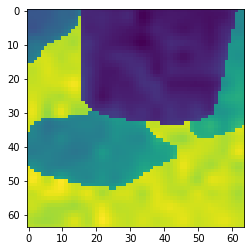

In [6]:
## Move camera to grasp offset frame
grasp_center = grasps[0].pose.translation
# Unfortunately VGN/GIGA grasps are not in the grasp frame we want (frame similar to PointNetGPD), so we need to transform them
grasp_frame_rot =  grasps[0].pose.rotation * Rotation.from_euler('Y', np.pi/2) * Rotation.from_euler('Z', np.pi)
grasp_tf = Transform(grasp_frame_rot, grasp_center).as_matrix()
offset_pos =  (grasp_tf @ np.array([[-dist_from_gripper],[0],[0],[1.]]))[:3].squeeze() # Move to offset frame
# (Debug) viz the grasp center and offset_pos:
# visualizer.add_geometry(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grasp_center.reshape(1,3))))
# visualizer.add_geometry(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(offset_pos.reshape(1,3))))
# visualizer.show()

# Unfortunately the bullet renderer uses the OpenGL format so we have to use yet another extrinsic
grasp_up_axis = grasp_tf.T[2,:3] # np.array([0.0, 0.0, 1.0]) # grasp_tf z-axis
extrinsic_bullet = Transform.look_at(eye=offset_pos, center=grasp_center, up=grasp_up_axis)

## render image
depth_img = camera.render(extrinsic_bullet)[1]
# Optional: Add some dex noise like GIGA
if add_noise:
    depth_img = apply_noise(depth_img, noise_type=noise_type, gp_rate=gp_rate)
plt.imshow(depth_img)


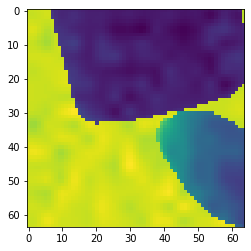

In [7]:
## Do the same for the other cameras
if three_cameras:
    ## Move camera to finger offset frame
    fingers_center =  (grasp_tf @ np.array([[sim.gripper.finger_depth/2.0],[0],[0],[1.]]))[:3].squeeze()
    left_finger_offset_pos  =  (grasp_tf @ np.array([[sim.gripper.finger_depth/2.0],[ (dist_from_finger + sim.gripper.max_opening_width/2.0)],[0],[1.]]))[:3].squeeze()
    right_finger_offset_pos =  (grasp_tf @ np.array([[sim.gripper.finger_depth/2.0],[-(dist_from_finger + sim.gripper.max_opening_width/2.0)],[0],[1.]]))[:3].squeeze()
    
    # Unfortunately the bullet renderer uses the OpenGL format so we have to use yet another extrinsic
    left_finger_extrinsic_bullet  = Transform.look_at(eye=left_finger_offset_pos,  center=fingers_center, up=grasp_up_axis)
    right_finger_extrinsic_bullet = Transform.look_at(eye=right_finger_offset_pos, center=fingers_center, up=grasp_up_axis)

    ## render image
    left_finger_depth_img  = finger_camera.render(left_finger_extrinsic_bullet )[1]
    right_finger_depth_img = finger_camera.render(right_finger_extrinsic_bullet)[1]
    # Optional: Add some dex noise like GIGA
    if add_noise:
        left_finger_depth_img = apply_noise(left_finger_depth_img, noise_type=noise_type, gp_rate=gp_rate)
        right_finger_depth_img = apply_noise(right_finger_depth_img, noise_type=noise_type, gp_rate=gp_rate)
    # Viz
    plt.imshow(left_finger_depth_img)
    plt.imshow(right_finger_depth_img)

In [8]:
# ## Convert to point cloud (TODO: Do this yourself with filtering)
# camera_mat_o3d = o3d.camera.PinholeCameraIntrinsic(128, 128, intrinsic.K[0,0], intrinsic.K[1,1], intrinsic.K[0,2], intrinsic.K[1,2])
# grasp_cam_local_depth_pc = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(depth_img), camera_mat_o3d, extrinsic_bullet.as_matrix(), depth_scale=1.0)
# # grasp_cam_local_depth_pc = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(depth_img), camera_mat_o3d, depth_scale=1.0)


# ## Viz point cloud and grasp
# grasp_cam_local_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 0, 1]), (np.asarray(grasp_cam_local_depth_pc.points).shape[0], 1)))
# visualizer = JVisualizer()
# visualizer.add_geometry(grasp_cam_local_depth_pc)

# if three_cameras:
#     left_cam_local_depth_pc  = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(left_finger_depth_img),  camera_mat_o3d, left_finger_extrinsic_bullet.as_matrix(),  depth_scale=1.0)
#     right_cam_local_depth_pc = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(right_finger_depth_img), camera_mat_o3d, right_finger_extrinsic_bullet.as_matrix(), depth_scale=1.0)
#     left_cam_local_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([1, 0, 0]), (np.asarray(left_cam_local_depth_pc.points).shape[0], 1)))
#     right_cam_local_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 1, 0]), (np.asarray(right_cam_local_depth_pc.points).shape[0], 1)))
#     visualizer.add_geometry(left_cam_local_depth_pc)
#     visualizer.add_geometry(right_cam_local_depth_pc)

# visualizer.show()

In [9]:
## Convert to point cloud
pixel_grid = np.meshgrid(np.arange(width), np.arange(height))
pixels = np.dstack((pixel_grid[0],pixel_grid[1])).reshape(-1, 2)

# depth_eps = 0.0001
depth_array = depth_img.reshape(-1)
relevant_mask = depth_array < (max_measured_dist) #- depth_eps) # only depth values in range

filt_pixels = np.array(pixels[relevant_mask]) # only consider pixels with depth values in range
filt_pixels = np.hstack((filt_pixels, np.ones((filt_pixels.shape[0], 2)))) # Homogenous co-ordinates
# Project pixels into camera space
filt_pixels[:,:3] *= depth_array[relevant_mask].reshape(-1, 1) # Multiply by depth
intrinsic_hom = np.eye(4)
intrinsic_hom[:3,:3] = intrinsic.K
p_local = np.linalg.inv(intrinsic_hom) @ filt_pixels.T
# Also filter out points that are more than max dist height # Not required if filtering combined cloud
# p_local = p_local[:, p_local[1,:] <  height_max_dist]
# p_local = p_local[:, p_local[1,:] > -height_max_dist]
p_world = np.linalg.inv(extrinsic_bullet.as_matrix()) @ p_local

## Viz point cloud and grasp
# grasp_cam_local_depth_pc = o3d.geometry.PointCloud()
# grasp_cam_local_depth_pc.points = o3d.utility.Vector3dVector(p_local[:3,:].T)
grasp_cam_world_depth_pc = o3d.geometry.PointCloud()
grasp_cam_world_depth_pc.points = o3d.utility.Vector3dVector(p_world[:3,:].T)
# grasp_cam_local_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 1, 1]), (np.asarray(grasp_cam_local_depth_pc.points).shape[0], 1)))
grasp_cam_world_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 0, 1]), (np.asarray(grasp_cam_world_depth_pc.points).shape[0], 1)))
# visualizer = JVisualizer()
# visualizer.add_geometry(grasp_cam_local_depth_pc)
visualizer.add_geometry(grasp_cam_world_depth_pc)
# viz original pc and gripper
o3d_gripper_mesh = as_mesh(grasps_scene).as_open3d
gripper_pc = o3d_gripper_mesh.sample_points_uniformly(number_of_points=3000)
gripper_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([1, 1, 0]), (np.asarray(gripper_pc.points).shape[0], 1)))
visualizer.add_geometry(gripper_pc)

if three_cameras:
    left_finger_depth_array = left_finger_depth_img.reshape(-1)
    left_relevant_mask = left_finger_depth_array < (finger_max_measured_dist)# - depth_eps) # only depth values in range
    left_filt_pixels = np.array(pixels[left_relevant_mask]) # only consider pixels with depth values in range
    
    left_filt_pixels = np.hstack((left_filt_pixels, np.ones((left_filt_pixels.shape[0], 2)))) # Homogenous co-ordinates
    # Project pixels into camera space
    left_filt_pixels[:,:3] *= left_finger_depth_array[left_relevant_mask].reshape(-1, 1) # Multiply by depth
    left_p_local = np.linalg.inv(intrinsic_hom) @ left_filt_pixels.T
    # Also filter out points that are more than max dist height and width # Not required if filtering combined cloud
    # left_p_local = left_p_local[:, left_p_local[0,:] <  finger_width_max_dist]
    # left_p_local = left_p_local[:, left_p_local[0,:] > -finger_width_max_dist]
    # left_p_local = left_p_local[:, left_p_local[1,:] <  finger_height_max_dist]
    # left_p_local = left_p_local[:, left_p_local[1,:] > -finger_height_max_dist]
    left_p_world = np.linalg.inv(left_finger_extrinsic_bullet.as_matrix()) @ left_p_local

    right_finger_depth_array = right_finger_depth_img.reshape(-1)
    right_relevant_mask = right_finger_depth_array < (finger_max_measured_dist)# - depth_eps) # only depth values in range
    right_filt_pixels = np.array(pixels[right_relevant_mask]) # only consider pixels with depth values in range
    
    right_filt_pixels = np.hstack((right_filt_pixels, np.ones((right_filt_pixels.shape[0], 2)))) # Homogenous co-ordinates
    # Project pixels into camera space
    right_filt_pixels[:,:3] *= right_finger_depth_array[right_relevant_mask].reshape(-1, 1) # Multiply by depth
    right_p_local = np.linalg.inv(intrinsic_hom) @ right_filt_pixels.T
    # Also filter out points that are more than max dist height and width # Not required if filtering combined cloud
    # right_p_local = right_p_local[:, right_p_local[0,:] <  finger_width_max_dist]
    # right_p_local = right_p_local[:, right_p_local[0,:] > -finger_width_max_dist]
    # right_p_local = right_p_local[:, right_p_local[1,:] <  finger_height_max_dist]
    # right_p_local = right_p_local[:, right_p_local[1,:] > -finger_height_max_dist]
    right_p_world = np.linalg.inv(right_finger_extrinsic_bullet.as_matrix()) @ right_p_local    

    # Viz
    left_cam_world_depth_pc = o3d.geometry.PointCloud()
    left_cam_world_depth_pc.points = o3d.utility.Vector3dVector(left_p_world[:3,:].T)
    right_cam_world_depth_pc = o3d.geometry.PointCloud()
    right_cam_world_depth_pc.points = o3d.utility.Vector3dVector(right_p_world[:3,:].T)

    left_cam_world_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([1, 0, 0]), (np.asarray(left_cam_world_depth_pc.points).shape[0], 1)))
    right_cam_world_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 1, 0]), (np.asarray(right_cam_world_depth_pc.points).shape[0], 1)))
    visualizer.add_geometry(left_cam_world_depth_pc)
    visualizer.add_geometry(right_cam_world_depth_pc)

visualizer.show()

JVisualizer with 5 geometries

In [10]:
# Combine and downsample surface point cloud
combined_world_points = np.hstack((p_world, left_p_world, right_p_world))
# filter points that are too far away
combined_world_points_local = np.linalg.inv(grasp_tf) @ combined_world_points
inval_mask = combined_world_points_local[0,:] > (max_measured_dist - dist_from_gripper) # too far X
inval_mask = inval_mask | (combined_world_points_local[0,:] < -dist_from_gripper)       # too close X
inval_mask = inval_mask | (combined_world_points_local[2,:] >  height_max_dist)         # too far Z
inval_mask = inval_mask | (combined_world_points_local[2,:] < -height_max_dist)         # too close Z
combined_world_points_filt = combined_world_points[:, ~inval_mask]

combined_pc = o3d.geometry.PointCloud()
combined_pc.points = o3d.utility.Vector3dVector(combined_world_points_filt[:3,:].T)

down_combined_pc = combined_pc.voxel_down_sample(voxel_size=voxel_downsample_size)
# If more than max points, uniformly sample
if len(down_combined_pc.points) > max_points:
    indices = np.random.choice(np.arange(len(down_combined_pc.points)), max_points, replace=False)
    down_combined_pc = down_combined_pc.select_by_index(indices)
down_combined_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([1.0, 0.45, 0.]), (np.asarray(down_combined_pc.points).shape[0], 1)))
visualizer2 = JVisualizer()
visualizer2.add_geometry(down_combined_pc)
# viz original pc and gripper
visualizer2.add_geometry(pc)
visualizer2.add_geometry(gripper_pc)
visualizer2.show()
down_combined_pc

JVisualizer with 3 geometries

PointCloud with 1023 points.

In [11]:
# grasp_pc_path = '/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/pile/data_pile_train_random_raw_HiRes_tiny/grasp_point_clouds/10.npz'
# grasp_pc = np.load(grasp_pc_path)['pc']
# temp_pc = o3d.geometry.PointCloud()
# temp_pc.points = o3d.utility.Vector3dVector(grasp_pc)
# temp_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.0, 0.45, 0.8]), (np.asarray(temp_pc.points).shape[0], 1)))
# visualizer2.add_geometry(temp_pc)
# visualizer2.show()

In [12]:
# Check occupancy of grasp surf points
from neugraspnet.utils.implicit import get_scene_from_mesh_pose_list
from neugraspnet.src.network.utils.libmesh import check_mesh_contains

def get_occ_specific_points(mesh_list, points):
    num_point = points.shape[0]
    occ = np.zeros(num_point).astype(bool)
    for mesh in mesh_list:
        occi = check_mesh_contains(mesh, points)
        occ = occ | occi
    
    return points, occ

points = np.asarray(down_combined_pc.points)
# for mesh_path, scale, pose in mesh_pose_list:
    # mesh_path = os.path.join(data_root, mesh_path)
for i in range(len(mesh_pose_list)):
    mesh_pose_list[i][0] = os.path.join(data_root, mesh_pose_list[i][0])
scene, mesh_list = get_scene_from_mesh_pose_list(mesh_pose_list, return_list=True)
points, occ = get_occ_specific_points(mesh_list, points)


In [13]:
points.shape, occ.sum()

((1023, 3), 461)

In [14]:
occ_pc = o3d.geometry.PointCloud()
not_occ_pc = o3d.geometry.PointCloud()
occ_pc.points = o3d.utility.Vector3dVector(points[occ])
not_occ_pc.points = o3d.utility.Vector3dVector(points[~occ])

occ_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.0, 0.45, 0.9]), (np.asarray(occ_pc.points).shape[0], 1)))
not_occ_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.4, 0.9, 0.45]), (np.asarray(not_occ_pc.points).shape[0], 1)))
visualizer3 = JVisualizer()
# visualizer3.add_geometry(down_combined_pc)
# # viz original pc and gripper
# visualizer3.add_geometry(pc)
visualizer3.add_geometry(gripper_pc)
visualizer3.add_geometry(occ_pc)
visualizer3.add_geometry(not_occ_pc)
visualizer3.show()

JVisualizer with 3 geometries

In [15]:
# import numpy as np
# id = 2097097
# occ_data = np.load('/work/scratch/sj93qicy/potato-net/data/pile/data_pile_train_random_raw_2M_GPG_MIXED/occ_grasp_point_clouds_noisy/'+str(id)+'.npz')
# points = occ_data['points']
# occ = occ_data['occ']
# grasp_pc_data = np.load('/work/scratch/sj93qicy/potato-net/data/pile/data_pile_train_random_raw_2M_GPG_MIXED/grasp_point_clouds_gt/'+str(id)+'.npz')
# grasp_pc = grasp_pc_data['pc']
# import open3d as o3d
# from open3d import JVisualizer
# visualizer4 = JVisualizer()
# occ_pc = o3d.geometry.PointCloud()
# not_occ_pc = o3d.geometry.PointCloud()
# occ_pc.points = o3d.utility.Vector3dVector(points[occ])
# not_occ_pc.points = o3d.utility.Vector3dVector(points[~occ])
# grasp_pc_o3d = o3d.geometry.PointCloud()
# grasp_pc_o3d.points = o3d.utility.Vector3dVector(grasp_pc)

# occ_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.0, 0.45, 0.9]), (np.asarray(occ_pc.points).shape[0], 1)))
# not_occ_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.4, 0.9, 0.45]), (np.asarray(not_occ_pc.points).shape[0], 1)))
# grasp_pc_o3d.colors = o3d.utility.Vector3dVector(np.tile(np.array([1.0, 0.45, 0.0]), (np.asarray(grasp_pc_o3d.points).shape[0], 1)))
# visualizer4.add_geometry(occ_pc)
# visualizer4.add_geometry(not_occ_pc)
# visualizer4.add_geometry(grasp_pc_o3d)
# visualizer4.show()


FileNotFoundError: [Errno 2] No such file or directory: '/work/scratch/sj93qicy/potato-net/data/pile/data_pile_train_random_raw_2M_GPG_MIXED/occ_grasp_point_clouds_noisy/2097097.npz'